# Rat LPS Bootstrapping

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import vampire as vp
from sklearn import manifold, cluster
from numpy.random import default_rng
from matplotlib import cm

In [4]:
vp.plot.set_plot_style()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [13]:
output_path = r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-lps/4-vampire-analysis-data'
model_path = os.path.join(output_path, 'model_rat-lps_(50_5_30)__.pickle')
vampire_model = vp.util.read_pickle(model_path)
property_path = os.path.join(output_path, 'apply-properties_rat-lps_on_rat-lps_(50_5_30)__.pickle')
apply_properties_df = vp.util.read_pickle(property_path)
normalized_contours = np.vstack(apply_properties_df["normalized_contour"].values)

In [14]:
def label_df(properties_df, id_df, target_props, search_prop='filename'):
    """
    properties_df : DataFrame
        Contains "filename" column
    id_df : DataFrame
        Contains columns listed in `properties` and "regex" column.
    target_props : list
        List of property(s) to be added. Must match column name in `id_df`.
    """
    properties_df = properties_df.copy()
    properties_df[target_props] = np.nan
    for i in range(id_df['regex'].size):
        mask = properties_df[search_prop].astype(str).str.contains(id_df['regex'][i], case=False)
        properties_df.loc[mask, target_props] = id_df.iloc[i, :][target_props].values
    return properties_df

In [18]:
treatment_id_df = pd.read_excel(r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-lps/3-data-labels/treatment-labels.xlsx')
treatment_id_df.head()

,id,treatment,regex,treatment_color
0,LPS_1ug,LPS 1 ug,LPS_1ug(?!_serum),#757575
1,LPS_100ng,LPS 0.1 ug,LPS_100ng,#00ACC1
2,NT,NC,NT(?!_serum),#1E88E5
3,LPS_1ug_serum,LPS 1 ug + Serum,LPS_1ug_serum,#3949AB
4,LPS_10ug,LPS 10 ug,LPS_10ug,#FDD835


In [19]:
apply_properties_df = label_df(apply_properties_df, treatment_id_df, ['treatment'])

In [77]:
rng = default_rng(seed=1)
subsample_ratio = 0.99  # controls number of points that constitute a bootstrapped dataset
num_resample = 500  # number of bootstrapped dataset generated
num_pc = 10
all_treatments = np.unique(apply_properties_df['treatment'])
num_treatments = len(all_treatments)
# all_mean_bootstrapped_treatment_contours = np.zeros((num_treatments*num_resample, 100))
all_mean_bootstrapped_treatment_contours_df = pd.DataFrame({
    'bootstrapped_contours': [],
    'treatment': [],
})
for n_treatment, treatment in enumerate(all_treatments):
    treatment_cond = apply_properties_df['treatment'] == treatment
    mean_bootstrapped_treatment_contours = np.zeros((num_resample, 100))
    num_subsample = int(np.sum(treatment_cond) * subsample_ratio)  # number of points that constitute a bootstrapped dataset
    for n_resample in range(num_resample):
        # generate one bootstrapped dataset and calculate mean
        bootstrapped_treatment_contours = rng.choice(normalized_contours[treatment_cond], size=num_subsample, replace=False)
        mean_bootstrapped_treatment_contour = bootstrapped_treatment_contours.mean(axis=0)
        mean_bootstrapped_treatment_contours[n_resample, :] = mean_bootstrapped_treatment_contour
    mean_bootstrapped_treatment_contours_df = pd.DataFrame({
        'bootstrapped_contours': mean_bootstrapped_treatment_contours.tolist(),
        'treatment': [treatment] * num_resample,
    })
    all_mean_bootstrapped_treatment_contours_df = pd.concat([all_mean_bootstrapped_treatment_contours_df, mean_bootstrapped_treatment_contours_df])
all_mean_bootstrapped_treatment_contours_df = all_mean_bootstrapped_treatment_contours_df.reset_index()
all_mean_bootstrapped_treatment_contours_df = label_df(all_mean_bootstrapped_treatment_contours_df, treatment_id_df, ['treatment_color'], 'treatment')
# PCA bootstrapped contours
all_mean_bootstrapped_treatment_contours = np.stack(all_mean_bootstrapped_treatment_contours_df['bootstrapped_contours'].to_numpy())
principal_directions, principal_components, explained_variance = vp.amath.pca(all_mean_bootstrapped_treatment_contours)
trunc_principal_components = principal_components[:, :num_pc]
explained_variance_ratio = explained_variance / sum(explained_variance)

(0.0, 1.05)

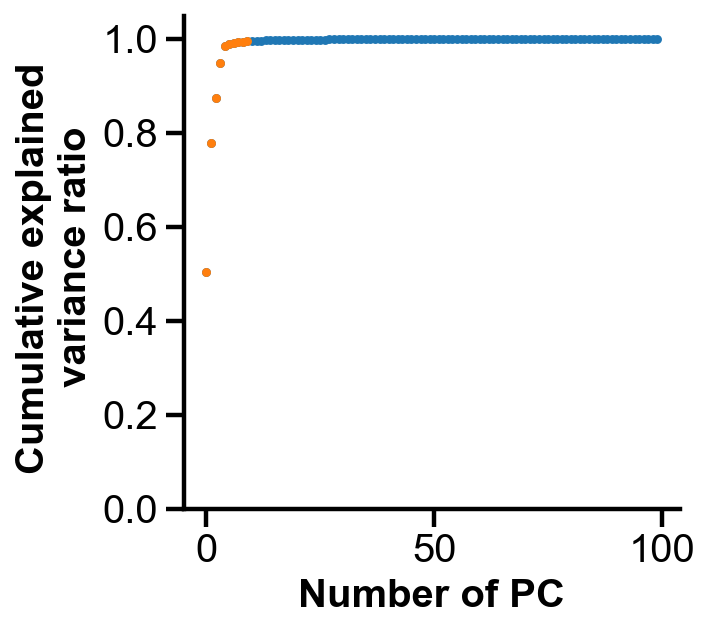

In [78]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(np.cumsum(explained_variance_ratio), '.')
ax.plot(np.cumsum(explained_variance_ratio)[:10], '.')
ax.set_xlabel('Number of PC')
ax.set_ylabel('Cumulative explained \n variance ratio')
ax.set_ylim(0, 1.05)

Text(0.5, 1.0, 'Rat LPS (x/n = 0.99)')

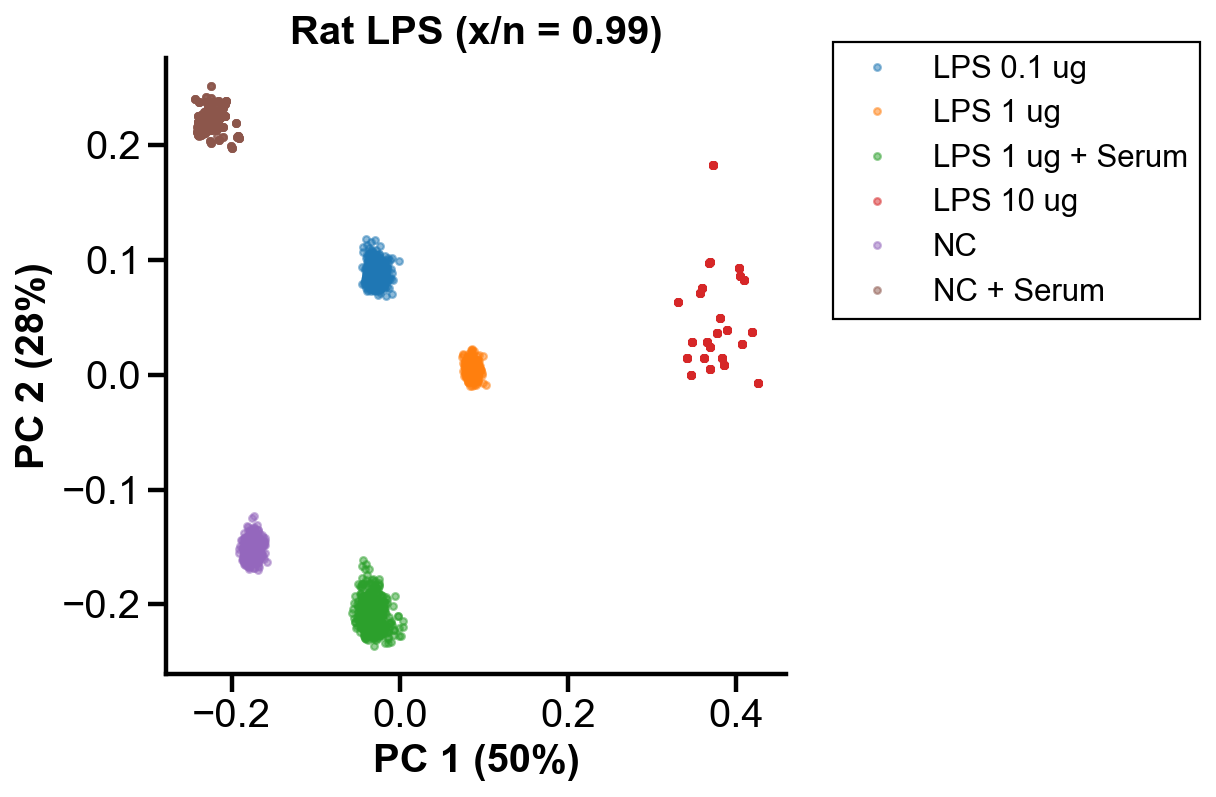

In [79]:
fig, ax = plt.subplots(figsize=(5, 5))
for n_treatment, treatment in enumerate(all_treatments):
    ax.plot(
        trunc_principal_components[n_treatment*num_resample:(n_treatment+1)*num_resample, 0], 
        trunc_principal_components[n_treatment*num_resample:(n_treatment+1)*num_resample, 1],
        '.', alpha=0.5,
        # c=all_mean_bootstrapped_treatment_contours_df['treatment_color'].iloc[n_treatment*num_resample],
        label=treatment,
    )
ax.legend(bbox_to_anchor=(1.05, 1.05))
ax.set_xlabel(f"PC 1 ({round(explained_variance_ratio[0]*100)}%)")
ax.set_ylabel(f"PC 2 ({round(explained_variance_ratio[1]*100)}%)")
ax.set_title(f'Rat LPS (x/n = {subsample_ratio})')

Text(0.5, 1.0, 'Rat LPS (x/n = 0.99)')

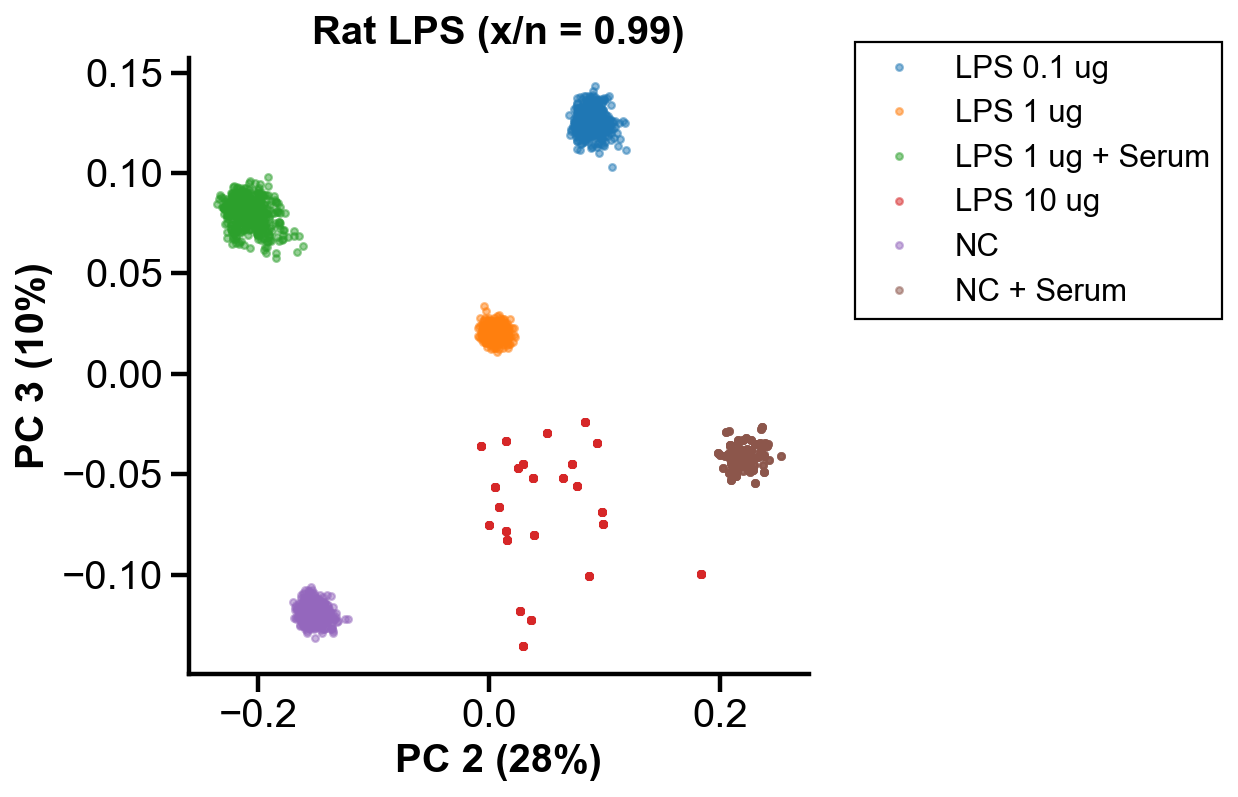

In [80]:
fig, ax = plt.subplots(figsize=(5, 5))
for n_treatment, treatment in enumerate(all_treatments):
    ax.plot(
        trunc_principal_components[n_treatment*num_resample:(n_treatment+1)*num_resample, 1], 
        trunc_principal_components[n_treatment*num_resample:(n_treatment+1)*num_resample, 2],
        '.', alpha=0.5,
        # c=all_mean_bootstrapped_treatment_contours_df['treatment_color'].iloc[n_treatment*num_resample],
        label=treatment,
    )
ax.legend(bbox_to_anchor=(1.05, 1.05))
ax.set_xlabel(f"PC 2 ({round(explained_variance_ratio[1]*100)}%)")
ax.set_ylabel(f"PC 3 ({round(explained_variance_ratio[2]*100)}%)")
ax.set_title(f'Rat LPS (x/n = {subsample_ratio})')